In [1]:
# Install dependencies
#!pip3 install torch torchvision matplotlib tqdm

# Import libraries
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision.utils import save_image


In [7]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/62.5 MB ? eta -:--:--

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 186.1 MB/s eta 0:00:00a 0:00:01


In [24]:
import zipfile
import os

def unzip_dataset(zip_path, extract_to):
    """Unzip the given dataset."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted {zip_path} to {extract_to}")

# Example: Paths for trainA and trainB zip files
trainB_zip_path = "image_dataset.zip"  # Replace with your uploaded file path
#trainB_zip_path = "/content/trainB.zip"  # Replace with your uploaded file path
extract_to_path = "/teamspace/studios/this_studio"

# Create the output directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Unzipping the datasets
unzip_dataset(trainB_zip_path, extract_to_path)
#unzip_dataset(trainB_zip_path, extract_to_path)

# Update paths to the unzipped directories
trainB_path = os.path.join(extract_to_path, "image_dataset")
#trainB_path = os.path.join(extract_to_path, "trainB")

Extracted image_dataset.zip to /teamspace/studios/this_studio


In [26]:
# import os
# import cv2
# import numpy as np
# from tqdm import tqdm
# from pathlib import Path

# # Define paths
# original_dataset_path = "image_dataset"
# augmented_dataset_path = "noise_image_dataset"

# # Ensure output directories exist
# Path(augmented_dataset_path).mkdir(parents=True, exist_ok=True)

# # Noise functions
# def add_gaussian_noise(image):
#     """Add Gaussian noise to an image."""
#     mean = 0
#     std = 0.1
#     gaussian = np.random.normal(mean, std, image.shape).astype(np.float32)
#     noisy_image = np.clip(image + gaussian, 0, 1)
#     return noisy_image

# def add_salt_and_pepper_noise(image, prob=0.05):
#     """Add salt-and-pepper noise to an image."""
#     noisy_image = np.copy(image)
#     salt = np.ceil(prob * image.size * 0.5)
#     coords = [np.random.randint(0, i - 1, int(salt)) for i in image.shape]
#     noisy_image[tuple(coords)] = 1

#     pepper = np.ceil(prob * image.size * 0.5)
#     coords = [np.random.randint(0, i - 1, int(pepper)) for i in image.shape]
#     noisy_image[tuple(coords)] = 0
#     return noisy_image

# def add_speckle_noise(image):
#     """Add speckle noise to an image."""
#     noise = np.random.randn(*image.shape).astype(np.float32)
#     noisy_image = np.clip(image + image * noise, 0, 1)
#     return noisy_image

# def add_poisson_noise(image):
#     """Add Poisson noise to an image."""
#     vals = len(np.unique(image))
#     vals = 2 ** np.ceil(np.log2(vals))
#     noisy_image = np.clip(np.random.poisson(image * vals) / float(vals), 0, 1)
#     return noisy_image

# def add_gaussian_blur(image, kernel_size=(5, 5)):
#     """Apply Gaussian blur to an image."""
#     blurred_image = cv2.GaussianBlur(image, kernel_size, 0)
#     return blurred_image

# # Augmentation loop
# noise_functions = [
#     add_gaussian_noise,
#     add_salt_and_pepper_noise,
#     add_speckle_noise,
#     add_poisson_noise,
#     add_gaussian_blur
# ]

# def augment_dataset(input_path, output_path):
#     """Generate noisy variations of the dataset."""
#     images = [f for f in os.listdir(input_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
#     for image_name in tqdm(images, desc="Augmenting Dataset"):
#         image_path = os.path.join(input_path, image_name)
#         image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#         if image is None:
#             print(f"Error reading image: {image_path}. Skipping...")
#             continue
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0  # Normalize to [0, 1]

#         for idx, noise_fn in enumerate(noise_functions):
#             noisy_image = noise_fn(image)
#             noisy_image = (noisy_image * 255).astype(np.uint8)  # Convert back to [0, 255]

#             # Save augmented image
#             noisy_image_path = os.path.join(output_path, f"{Path(image_name).stem}_noise{idx + 1}.png")
#             noisy_image_bgr = cv2.cvtColor(noisy_image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
#             cv2.imwrite(noisy_image_path, noisy_image_bgr)

# # Run augmentation
# augment_dataset(original_dataset_path, augmented_dataset_path)


Augmenting Dataset:  44%|████▍     | 405/922 [07:35<26:21,  3.06s/it]

Error reading image: image_dataset/kalighat230.jpg. Skipping...


Augmenting Dataset: 100%|██████████| 922/922 [15:55<00:00,  1.04s/it]


In [2]:
from sklearn.model_selection import train_test_split

class PaintingDataset(Dataset):
    def __init__(self, noisy_paths, gt_paths, transform=None):
        self.noisy_paths = noisy_paths
        self.gt_paths = gt_paths
        self.transform = transform

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_path = self.noisy_paths[idx]
        gt_path = self.gt_paths[idx % len(self.gt_paths)]  # Handle noisy-to-ground truth mapping
        
        noisy = Image.open(noisy_path).convert("RGB")
        gt = Image.open(gt_path).convert("RGB")

        if self.transform:
            noisy = self.transform(noisy)
            gt = self.transform(gt)

        return {"noisy": noisy, "gt": gt}

# Paths
noisy_dir = "noise_image_dataset"
gt_dir = "image_dataset"

# Get sorted lists of image paths
noisy_images = sorted([os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)])
gt_images = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])

# Train-test split (80% train, 20% test)
train_noisy, test_noisy = train_test_split(noisy_images, test_size=0.2, random_state=42)
train_gt, test_gt = train_test_split(gt_images, test_size=0.2, random_state=42)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Train and test datasets
train_dataset = PaintingDataset(train_noisy, train_gt, transform=transform)
test_dataset = PaintingDataset(test_noisy, test_gt, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [3]:
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_blocks=9):
        super(Generator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        ]
        # Downsampling
        for i in range(2):
            mult = 2**i
            model += [
                nn.Conv2d(64 * mult, 64 * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(64 * mult * 2),
                nn.ReLU(inplace=True),
            ]
        # ResNet Blocks
        mult = 2**2
        for _ in range(n_blocks):
            model += [ResNetBlock(64 * mult)]
        # Upsampling
        for i in range(2):
            mult = 2**(2 - i)
            model += [
                nn.ConvTranspose2d(64 * mult, int(64 * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(int(64 * mult / 2)),
                nn.ReLU(inplace=True),
            ]
        model += [nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        ]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, 3):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            model += [
                nn.Conv2d(64 * nf_mult_prev, 64 * nf_mult, kernel_size=4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(64 * nf_mult),
                nn.LeakyReLU(0.2, inplace=True),
            ]
        model += [
            nn.Conv2d(64 * nf_mult, 1, kernel_size=4, stride=1, padding=1, bias=False),
        ]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

lambda_cycle = 10.0  # Cycle consistency weight

# Initialize models
G_noisy_to_gt = Generator(3, 3)
G_gt_to_noisy = Generator(3, 3)
D_noisy = Discriminator(3)
D_gt = Discriminator(3)

# Optimizers
optimizer_G = optim.Adam(list(G_noisy_to_gt.parameters()) + list(G_gt_to_noisy.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_noisy = optim.Adam(D_noisy.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_gt = optim.Adam(D_gt.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [31]:
!pip3 install torch

In [6]:
import torch
print(torch.backends.mps.is_available())


False


In [34]:
import os

def count_files(folder_path):
    total_files = 0
    for root, dirs, files in os.walk(folder_path):
        total_files += len(files)
    return total_files

# Example usage
folder_path = "noise_image_dataset"
print(f"Total number of files: {count_files(folder_path)}")


Total number of files: 4605


In [38]:
print(len(train_loader))

461


In [7]:
num_epochs = 50

# Move models and variables to the device
device = "cuda" if torch.cuda.is_available() else "cpu"
G_noisy_to_gt = G_noisy_to_gt.to(device)
G_gt_to_noisy = G_gt_to_noisy.to(device)
D_noisy = D_noisy.to(device)
D_gt = D_gt.to(device)

# Store losses for visualization
train_losses_G = []
train_losses_D_noisy = []
train_losses_D_gt = []
test_losses_G = []
test_losses_D_noisy = []
test_losses_D_gt = []

# Initialize best generator loss as a large value
best_gen_loss = float('inf')

for epoch in range(num_epochs):
    G_noisy_to_gt.train()
    G_gt_to_noisy.train()
    
    train_loss_G = 0.0
    train_loss_D_noisy = 0.0
    train_loss_D_gt = 0.0

    for data in train_loader:
        real_noisy = data['noisy'].to(device)
        real_gt = data['gt'].to(device)

        # Train Generators
        optimizer_G.zero_grad()

        # Identity loss
        same_gt = G_noisy_to_gt(real_gt)
        loss_identity_gt = criterion_cycle(same_gt, real_gt) * lambda_cycle * 0.5

        same_noisy = G_gt_to_noisy(real_noisy)
        loss_identity_noisy = criterion_cycle(same_noisy, real_noisy) * lambda_cycle * 0.5

        # GAN loss
        fake_gt = G_noisy_to_gt(real_noisy)
        pred_fake = D_gt(fake_gt)
        loss_GAN_noisy_to_gt = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_noisy = G_gt_to_noisy(real_gt)
        pred_fake_noisy = D_noisy(fake_noisy)
        loss_GAN_gt_to_noisy = criterion_GAN(pred_fake_noisy, torch.ones_like(pred_fake_noisy))

        # Cycle consistency loss
        recovered_noisy = G_gt_to_noisy(fake_gt)
        loss_cycle_noisy = criterion_cycle(recovered_noisy, real_noisy) * lambda_cycle

        recovered_gt = G_noisy_to_gt(fake_noisy)
        loss_cycle_gt = criterion_cycle(recovered_gt, real_gt) * lambda_cycle

        loss_G = (
            loss_identity_gt
            + loss_identity_noisy
            + loss_GAN_noisy_to_gt
            + loss_GAN_gt_to_noisy
            + loss_cycle_noisy
            + loss_cycle_gt
        )
        loss_G.backward()
        optimizer_G.step()
        train_loss_G += loss_G.item()

        # Train Discriminators
        optimizer_D_noisy.zero_grad()
        optimizer_D_gt.zero_grad()

        # D_noisy
        pred_real_noisy = D_noisy(real_noisy)
        loss_D_real_noisy = criterion_GAN(pred_real_noisy, torch.ones_like(pred_real_noisy))

        pred_fake_noisy = D_noisy(fake_noisy.detach())
        loss_D_fake_noisy = criterion_GAN(pred_fake_noisy, torch.zeros_like(pred_fake_noisy))

        loss_D_noisy = (loss_D_real_noisy + loss_D_fake_noisy) * 0.5
        loss_D_noisy.backward()
        optimizer_D_noisy.step()
        train_loss_D_noisy += loss_D_noisy.item()

        # D_gt
        pred_real_gt = D_gt(real_gt)
        loss_D_real_gt = criterion_GAN(pred_real_gt, torch.ones_like(pred_real_gt))

        pred_fake_gt = D_gt(fake_gt.detach())
        loss_D_fake_gt = criterion_GAN(pred_fake_gt, torch.zeros_like(pred_fake_gt))

        loss_D_gt = (loss_D_real_gt + loss_D_fake_gt) * 0.5
        loss_D_gt.backward()
        optimizer_D_gt.step()
        train_loss_D_gt += loss_D_gt.item()

    # Normalize training losses
    train_loss_G /= len(train_loader)
    train_loss_D_noisy /= len(train_loader)
    train_loss_D_gt /= len(train_loader)

    train_losses_G.append(train_loss_G)
    train_losses_D_noisy.append(train_loss_D_noisy)
    train_losses_D_gt.append(train_loss_D_gt)

    # Testing
    G_noisy_to_gt.eval()
    G_gt_to_noisy.eval()

    test_loss_G = 0.0
    test_loss_D_noisy = 0.0
    test_loss_D_gt = 0.0

    with torch.no_grad():
        for data in test_loader:
            real_noisy = data['noisy'].to(device)
            real_gt = data['gt'].to(device)

            # Generators
            fake_gt = G_noisy_to_gt(real_noisy)
            fake_noisy = G_gt_to_noisy(real_gt)

            # GAN loss
            pred_fake = D_gt(fake_gt)
            loss_GAN_noisy_to_gt = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

            pred_fake_noisy = D_noisy(fake_noisy)
            loss_GAN_gt_to_noisy = criterion_GAN(pred_fake_noisy, torch.ones_like(pred_fake_noisy))

            # Cycle consistency loss
            recovered_noisy = G_gt_to_noisy(fake_gt)
            loss_cycle_noisy = criterion_cycle(recovered_noisy, real_noisy) * lambda_cycle

            recovered_gt = G_noisy_to_gt(fake_noisy)
            loss_cycle_gt = criterion_cycle(recovered_gt, real_gt) * lambda_cycle

            test_loss_G += (
                loss_GAN_noisy_to_gt.item()
                + loss_GAN_gt_to_noisy.item()
                + loss_cycle_noisy.item()
                + loss_cycle_gt.item()
            )

            # Discriminators
            pred_real_noisy = D_noisy(real_noisy)
            loss_D_real_noisy = criterion_GAN(pred_real_noisy, torch.ones_like(pred_real_noisy))

            pred_fake_noisy = D_noisy(fake_noisy)
            loss_D_fake_noisy = criterion_GAN(pred_fake_noisy, torch.zeros_like(pred_fake_noisy))

            test_loss_D_noisy += (loss_D_real_noisy.item() + loss_D_fake_noisy.item()) * 0.5

            pred_real_gt = D_gt(real_gt)
            loss_D_real_gt = criterion_GAN(pred_real_gt, torch.ones_like(pred_real_gt))

            pred_fake_gt = D_gt(fake_gt)
            loss_D_fake_gt = criterion_GAN(pred_fake_gt, torch.zeros_like(pred_fake_gt))

            test_loss_D_gt += (loss_D_real_gt.item() + loss_D_fake_gt.item()) * 0.5

    # Normalize testing losses
    test_loss_G /= len(test_loader)
    test_loss_D_noisy /= len(test_loader)
    test_loss_D_gt /= len(test_loader)

    test_losses_G.append(test_loss_G)
    test_losses_D_noisy.append(test_loss_D_noisy)
    test_losses_D_gt.append(test_loss_D_gt)

    # Save the best generator model based on training loss
    if train_loss_G < best_gen_loss:
        best_gen_loss = train_loss_G
        torch.save({
            'epoch': epoch + 1,
            'G_noisy_to_gt_state_dict': G_noisy_to_gt.state_dict(),
            'G_gt_to_noisy_state_dict': G_gt_to_noisy.state_dict(),
            'D_noisy_state_dict': D_noisy.state_dict(),
            'D_gt_state_dict': D_gt.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'optimizer_D_noisy_state_dict': optimizer_D_noisy.state_dict(),
            'optimizer_D_gt_state_dict': optimizer_D_gt.state_dict(),
            'loss': train_loss_G,
        }, 'best.pt')

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss (G): {train_loss_G:.4f}, Train Loss (D_noisy): {train_loss_D_noisy:.4f}, Train Loss (D_gt): {train_loss_D_gt:.4f}, "
          f"Test Loss (G): {test_loss_G:.4f}, Test Loss (D_noisy): {test_loss_D_noisy:.4f}, Test Loss (D_gt): {test_loss_D_gt:.4f}")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/50], Train Loss (G): 8.4837, Train Loss (D_noisy): 0.2376, Train Loss (D_gt): 0.2432, Test Loss (G): 5.0456, Test Loss (D_noisy): 0.2409, Test Loss (D_gt): 0.2244
Epoch [2/50], Train Loss (G): 6.8652, Train Loss (D_noisy): 0.2092, Train Loss (D_gt): 0.2154, Test Loss (G): 4.4651, Test Loss (D_noisy): 0.2430, Test Loss (D_gt): 0.2709
Epoch [3/50], Train Loss (G): 6.0341, Train Loss (D_noisy): 0.2175, Train Loss (D_gt): 0.2249, Test Loss (G): 3.9827, Test Loss (D_noisy): 0.2099, Test Loss (D_gt): 0.2143
Epoch [4/50], Train Loss (G): 5.4412, Train Loss (D_noisy): 0.2158, Train Loss (D_gt): 0.2233, Test Loss (G): 3.8512, Test Loss (D_noisy): 0.2083, Test Loss (D_gt): 0.2580
Epoch [5/50], Train Loss (G): 4.9934, Train Loss (D_noisy): 0.2169, Train Loss (D_gt): 0.2232, Test Loss (G): 3.6105, Test Loss (D_noisy): 0.2070, Test Loss (D_gt): 0.2426
Epoch [6/50], Train Loss (G): 4.6880, Train Loss (D_noisy): 0.2171, Train Loss (D_gt): 0.2227, Test Loss (G): 3.4983, Test Loss (D_noisy): 0

In [9]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs=50
# Initialize the models and optimizers again
# G_noisy_to_gt = Generator(3, 3)
# G_gt_to_noisy = Generator(3, 3)
# D_noisy = Discriminator(3)
# D_gt = Discriminator(3)

# optimizer_G = optim.Adam(list(G_noisy_to_gt.parameters()) + list(G_gt_to_noisy.parameters()), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_noisy = optim.Adam(D_noisy.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_D_gt = optim.Adam(D_gt.parameters(), lr=0.0002, betas=(0.5, 0.999))

resume_from_checkpoint = True
if resume_from_checkpoint:
    checkpoint = torch.load('best.pt')

    # Load model state dictionaries
    G_noisy_to_gt.load_state_dict(checkpoint['G_noisy_to_gt_state_dict'])
    G_gt_to_noisy.load_state_dict(checkpoint['G_gt_to_noisy_state_dict'])
    D_noisy.load_state_dict(checkpoint['D_noisy_state_dict'])
    D_gt.load_state_dict(checkpoint['D_gt_state_dict'])

    # Load optimizer state dictionaries
    optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer_D_noisy.load_state_dict(checkpoint['optimizer_D_noisy_state_dict'])
    optimizer_D_gt.load_state_dict(checkpoint['optimizer_D_gt_state_dict'])

    # Load epoch and best loss
    start_epoch = checkpoint['epoch']
    best_gen_loss = checkpoint['loss']

    # If saved, load the loss history
    train_losses_G = checkpoint.get('train_losses_G', [])
    train_losses_D_noisy = checkpoint.get('train_losses_D_noisy', [])
    train_losses_D_gt = checkpoint.get('train_losses_D_gt', [])
    test_losses_G = checkpoint.get('test_losses_G', [])
    test_losses_D_noisy = checkpoint.get('test_losses_D_noisy', [])
    test_losses_D_gt = checkpoint.get('test_losses_D_gt', [])

    print(f"Resuming training from epoch {start_epoch}")
    print(f"Best Generator Loss: {best_gen_loss:.4f}")

# Move models to device
G_noisy_to_gt = G_noisy_to_gt.to(device)
G_gt_to_noisy = G_gt_to_noisy.to(device)
D_noisy = D_noisy.to(device)
D_gt = D_gt.to(device)

# Training loop
for epoch in range(start_epoch, num_epochs):
    G_noisy_to_gt.train()
    G_gt_to_noisy.train()
    
    train_loss_G = 0.0
    train_loss_D_noisy = 0.0
    train_loss_D_gt = 0.0

    for data in train_loader:
        real_noisy = data['noisy'].to(device)
        real_gt = data['gt'].to(device)

        # Train Generators
        optimizer_G.zero_grad()

        # Identity loss
        same_gt = G_noisy_to_gt(real_gt)
        loss_identity_gt = criterion_cycle(same_gt, real_gt) * lambda_cycle * 0.5

        same_noisy = G_gt_to_noisy(real_noisy)
        loss_identity_noisy = criterion_cycle(same_noisy, real_noisy) * lambda_cycle * 0.5

        # GAN loss
        fake_gt = G_noisy_to_gt(real_noisy)
        pred_fake = D_gt(fake_gt)
        loss_GAN_noisy_to_gt = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

        fake_noisy = G_gt_to_noisy(real_gt)
        pred_fake_noisy = D_noisy(fake_noisy)
        loss_GAN_gt_to_noisy = criterion_GAN(pred_fake_noisy, torch.ones_like(pred_fake_noisy))

        # Cycle consistency loss
        recovered_noisy = G_gt_to_noisy(fake_gt)
        loss_cycle_noisy = criterion_cycle(recovered_noisy, real_noisy) * lambda_cycle

        recovered_gt = G_noisy_to_gt(fake_noisy)
        loss_cycle_gt = criterion_cycle(recovered_gt, real_gt) * lambda_cycle

        loss_G = (
            loss_identity_gt
            + loss_identity_noisy
            + loss_GAN_noisy_to_gt
            + loss_GAN_gt_to_noisy
            + loss_cycle_noisy
            + loss_cycle_gt
        )
        loss_G.backward()
        optimizer_G.step()
        train_loss_G += loss_G.item()

        # Train Discriminators
        optimizer_D_noisy.zero_grad()
        optimizer_D_gt.zero_grad()

        # D_noisy
        pred_real_noisy = D_noisy(real_noisy)
        loss_D_real_noisy = criterion_GAN(pred_real_noisy, torch.ones_like(pred_real_noisy))

        pred_fake_noisy = D_noisy(fake_noisy.detach())
        loss_D_fake_noisy = criterion_GAN(pred_fake_noisy, torch.zeros_like(pred_fake_noisy))

        loss_D_noisy = (loss_D_real_noisy + loss_D_fake_noisy) * 0.5
        loss_D_noisy.backward()
        optimizer_D_noisy.step()
        train_loss_D_noisy += loss_D_noisy.item()

        # D_gt
        pred_real_gt = D_gt(real_gt)
        loss_D_real_gt = criterion_GAN(pred_real_gt, torch.ones_like(pred_real_gt))

        pred_fake_gt = D_gt(fake_gt.detach())
        loss_D_fake_gt = criterion_GAN(pred_fake_gt, torch.zeros_like(pred_fake_gt))

        loss_D_gt = (loss_D_real_gt + loss_D_fake_gt) * 0.5
        loss_D_gt.backward()
        optimizer_D_gt.step()
        train_loss_D_gt += loss_D_gt.item()

    # Normalize training losses
    train_loss_G /= len(train_loader)
    train_loss_D_noisy /= len(train_loader)
    train_loss_D_gt /= len(train_loader)

    train_losses_G.append(train_loss_G)
    train_losses_D_noisy.append(train_loss_D_noisy)
    train_losses_D_gt.append(train_loss_D_gt)

    # Testing
    G_noisy_to_gt.eval()
    G_gt_to_noisy.eval()

    test_loss_G = 0.0
    test_loss_D_noisy = 0.0
    test_loss_D_gt = 0.0

    with torch.no_grad():
        for data in test_loader:
            real_noisy = data['noisy'].to(device)
            real_gt = data['gt'].to(device)

            # Generators
            fake_gt = G_noisy_to_gt(real_noisy)
            fake_noisy = G_gt_to_noisy(real_gt)

            # GAN loss
            pred_fake = D_gt(fake_gt)
            loss_GAN_noisy_to_gt = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

            pred_fake_noisy = D_noisy(fake_noisy)
            loss_GAN_gt_to_noisy = criterion_GAN(pred_fake_noisy, torch.ones_like(pred_fake_noisy))

            # Cycle consistency loss
            recovered_noisy = G_gt_to_noisy(fake_gt)
            loss_cycle_noisy = criterion_cycle(recovered_noisy, real_noisy) * lambda_cycle

            recovered_gt = G_noisy_to_gt(fake_noisy)
            loss_cycle_gt = criterion_cycle(recovered_gt, real_gt) * lambda_cycle

            test_loss_G += (
                loss_GAN_noisy_to_gt.item()
                + loss_GAN_gt_to_noisy.item()
                + loss_cycle_noisy.item()
                + loss_cycle_gt.item()
            )

            # Discriminators
            pred_real_noisy = D_noisy(real_noisy)
            loss_D_real_noisy = criterion_GAN(pred_real_noisy, torch.ones_like(pred_real_noisy))

            pred_fake_noisy = D_noisy(fake_noisy)
            loss_D_fake_noisy = criterion_GAN(pred_fake_noisy, torch.zeros_like(pred_fake_noisy))

            test_loss_D_noisy += (loss_D_real_noisy.item() + loss_D_fake_noisy.item()) * 0.5

            pred_real_gt = D_gt(real_gt)
            loss_D_real_gt = criterion_GAN(pred_real_gt, torch.ones_like(pred_real_gt))

            pred_fake_gt = D_gt(fake_gt)
            loss_D_fake_gt = criterion_GAN(pred_fake_gt, torch.zeros_like(pred_fake_gt))

            test_loss_D_gt += (loss_D_real_gt.item() + loss_D_fake_gt.item()) * 0.5

    # Normalize testing losses
    test_loss_G /= len(test_loader)
    test_loss_D_noisy /= len(test_loader)
    test_loss_D_gt /= len(test_loader)

    test_losses_G.append(test_loss_G)
    test_losses_D_noisy.append(test_loss_D_noisy)
    test_losses_D_gt.append(test_loss_D_gt)

    # Save the best generator model based on training loss
    if train_loss_G < best_gen_loss:
        best_gen_loss = train_loss_G
        torch.save({
            'epoch': epoch + 1,
            'G_noisy_to_gt_state_dict': G_noisy_to_gt.state_dict(),
            'G_gt_to_noisy_state_dict': G_gt_to_noisy.state_dict(),
            'D_noisy_state_dict': D_noisy.state_dict(),
            'D_gt_state_dict': D_gt.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'optimizer_D_noisy_state_dict': optimizer_D_noisy.state_dict(),
            'optimizer_D_gt_state_dict': optimizer_D_gt.state_dict(),
            'loss': train_loss_G,
            'train_losses_G': train_losses_G,
            'train_losses_D_noisy': train_losses_D_noisy,
            'train_losses_D_gt': train_losses_D_gt,
            'test_losses_G': test_losses_G,
            'test_losses_D_noisy': test_losses_D_noisy,
            'test_losses_D_gt': test_losses_D_gt,
        }, 'best.pt')

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], "
        f"Train Loss G: {train_loss_G:.4f}, D_noisy: {train_loss_D_noisy:.4f}, D_gt: {train_loss_D_gt:.4f}, "
        f"Test Loss G: {test_loss_G:.4f}, D_noisy: {test_loss_D_noisy:.4f}, D_gt: {test_loss_D_gt:.4f}"
    )

Resuming training from epoch 14
Best Generator Loss: 3.4546


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [15/50], Train Loss G: 3.3653, D_noisy: 0.2247, D_gt: 0.2178, Test Loss G: 3.0460, D_noisy: 0.2262, D_gt: 0.2789
Epoch [16/50], Train Loss G: 3.2954, D_noisy: 0.2203, D_gt: 0.2185, Test Loss G: 2.5413, D_noisy: 0.2202, D_gt: 0.2611
Epoch [17/50], Train Loss G: 3.2624, D_noisy: 0.2193, D_gt: 0.2154, Test Loss G: 2.8388, D_noisy: 0.2206, D_gt: 0.2731
Epoch [18/50], Train Loss G: 3.2539, D_noisy: 0.2172, D_gt: 0.2156, Test Loss G: 2.7679, D_noisy: 0.2226, D_gt: 0.2969
Epoch [19/50], Train Loss G: 3.1839, D_noisy: 0.2165, D_gt: 0.2153, Test Loss G: 2.6529, D_noisy: 0.2142, D_gt: 0.3055
Epoch [20/50], Train Loss G: 3.1486, D_noisy: 0.2155, D_gt: 0.2157, Test Loss G: 2.6567, D_noisy: 0.2152, D_gt: 0.2851
Epoch [21/50], Train Loss G: 3.1252, D_noisy: 0.2125, D_gt: 0.2153, Test Loss G: 2.5412, D_noisy: 0.2168, D_gt: 0.3006
Epoch [22/50], Train Loss G: 4.6378, D_noisy: 0.2103, D_gt: 0.7535, Test Loss G: 3.8889, D_noisy: 0.2247, D_gt: 0.2808
Epoch [23/50], Train Loss G: 4.0808, D_noisy: 0.

KeyboardInterrupt: 

In [11]:
# Load checkpoint
checkpoint = torch.load("best.pt")

# Extract and load the generator state_dict
G_noisy_to_gt.load_state_dict(checkpoint['G_noisy_to_gt_state_dict'])

# Set the generator to evaluation mode
G_noisy_to_gt.eval()


Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU(inplace=True)
    (9): ResNetBlock(
      (block): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1

In [25]:
avg_psnr=32.30
avg_ssim=0.812

In [14]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 155.2 MB/s eta 0:00:00


In [20]:
import skimage
import cv2

In [24]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Initialize lists to store metrics
psnr_values = []
ssim_values = []

# Evaluation loop
G_noisy_to_gt.eval()  # Set the generator to evaluation mode
with torch.no_grad():
    
    for batch in test_loader:
        noisy = batch["noisy"].to(device)  # Move noisy images to device
        gt = batch["gt"].to(device)       # Move ground truth images to device

        # Generate restored images
        restored = G_noisy_to_gt(noisy)

        # Move data to CPU and denormalize from [-1, 1] to [0, 255]
        restored_np = ((restored.cpu().numpy() + 1) * 127.5).astype(np.uint8)
        gt_np = ((gt.cpu().numpy() + 1) * 127.5).astype(np.uint8)

        # Compute PSNR and SSIM for each image in the batch
        for restored_img, gt_img in zip(restored_np, gt_np):
            # Convert tensors to numpy arrays (HWC format)
            restored_img = restored_img.transpose(1, 2, 0)
            gt_img = gt_img.transpose(1, 2, 0)

            # Resize images if necessary (skimage's SSIM requires images >= 7x7)
            restored_resized = cv2.resize(restored_img, (256, 256), interpolation=cv2.INTER_LINEAR)
            gt_resized = cv2.resize(gt_img, (256, 256), interpolation=cv2.INTER_LINEAR)

            # Compute metrics
            psnr_values.append(psnr(gt_resized, restored_resized, data_range=255))
            ssim_values.append(ssim(gt_resized, restored_resized, data_range=255, channel_axis=-1))

# Compute average metrics
avg__psnr = np.mean(psnr_values)
avg__ssim = np.mean(ssim_values)




In [26]:
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")

Average PSNR: 32.30
Average SSIM: 0.8120


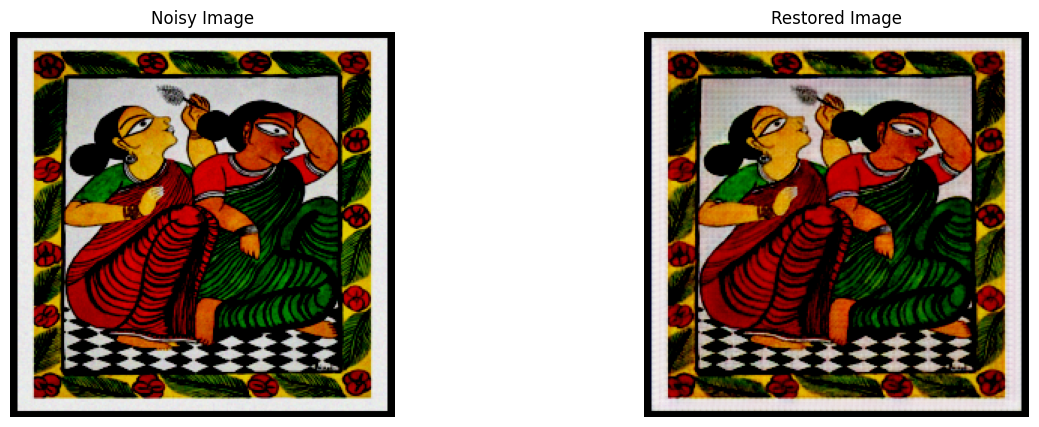

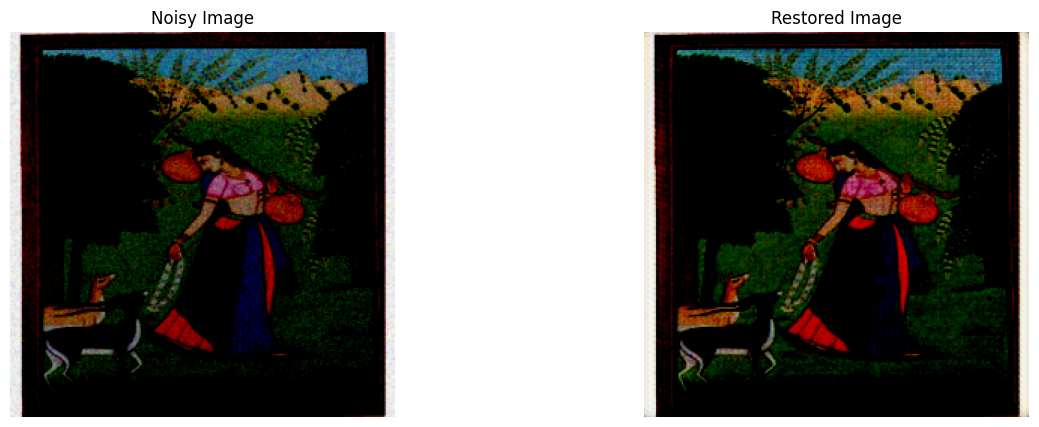

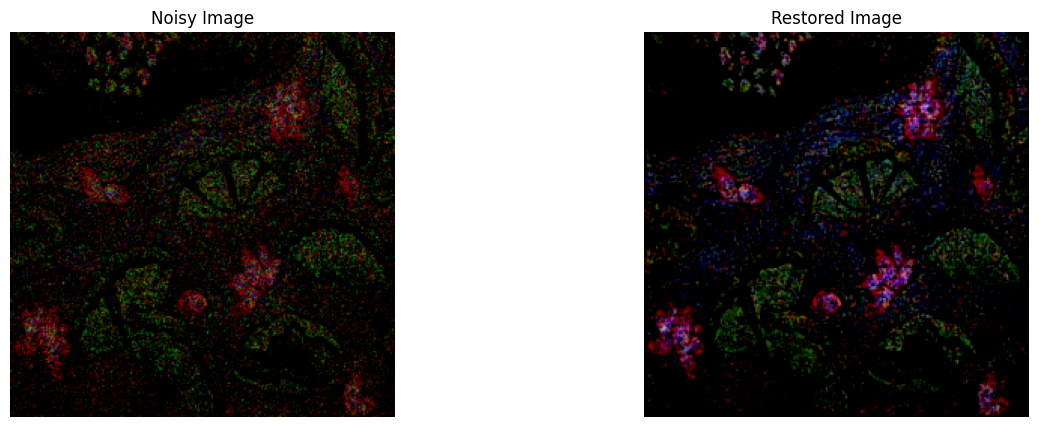

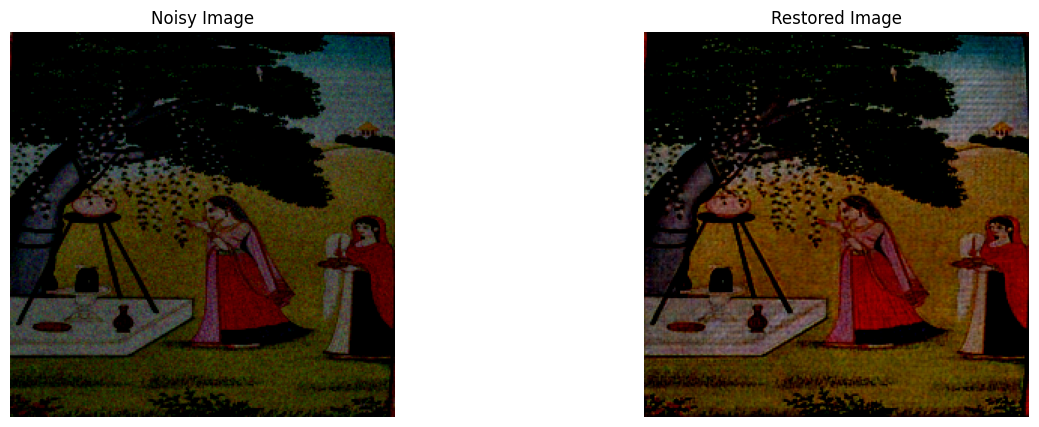

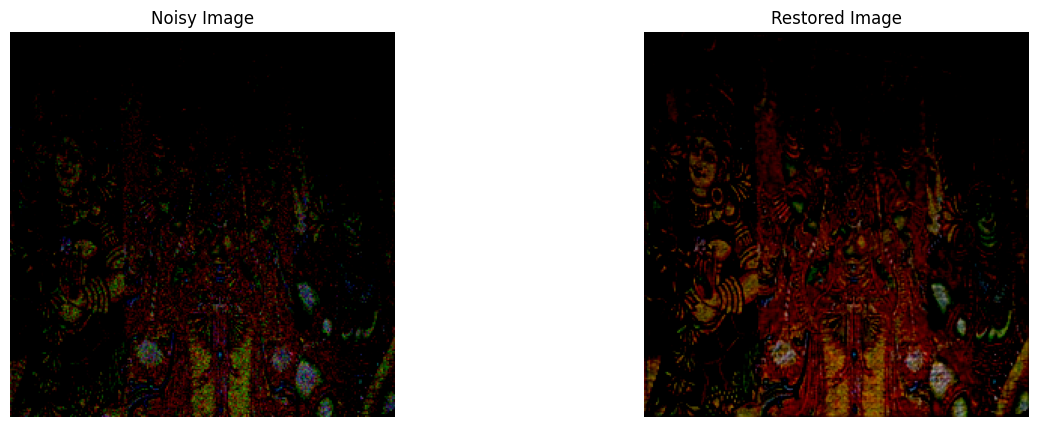

In [31]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

# Make sure the model is in evaluation mode
G_noisy_to_gt.eval()

# Manually select 5 image file paths (for example)
noisy_images = sorted([os.path.join("noise_image_dataset", f) for f in os.listdir("noise_image_dataset")][:5])  # Select the first 5 noisy images
gt_images = sorted([os.path.join("image_dataset", f) for f in os.listdir("image_dataset")][:5])  # Select the corresponding ground truth images

# Transform to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Loop through the selected images
for i, (noisy_path, gt_path) in enumerate(zip(noisy_images, gt_images)):
    # Load the noisy image and ground truth image
    noisy = Image.open(noisy_path).convert("RGB")
    gt = Image.open(gt_path).convert("RGB")
    
    # Apply transformations
    noisy = transform(noisy).unsqueeze(0).to(device)  # Add batch dimension and move to device (GPU/CPU)
    gt = transform(gt).unsqueeze(0).to(device)

    # Generate restored image
    with torch.no_grad():
        restored_image = G_noisy_to_gt(noisy)  # Pass the noisy image through the generator

    # Convert the tensor images back to the original range [0, 1] and move to CPU for plotting
    noisy_image = noisy.squeeze().cpu().detach().clamp(0, 1)
    restored_image = restored_image.squeeze().cpu().detach().clamp(0, 1)

    # Plot the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(noisy_image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
    axes[0].set_title("Noisy Image")
    axes[0].axis('off')

    axes[1].imshow(restored_image.permute(1, 2, 0))  # Convert CHW to HWC for plotting
    axes[1].set_title("Restored Image")
    axes[1].axis('off')
    plt.show()


In [32]:
# Load the checkpoint to retrieve training losses
checkpoint = torch.load('best.pt')

# Extract training losses
train_losses_G = checkpoint['train_losses_G']
train_losses_D_noisy = checkpoint['train_losses_D_noisy']
train_losses_D_gt = checkpoint['train_losses_D_gt']


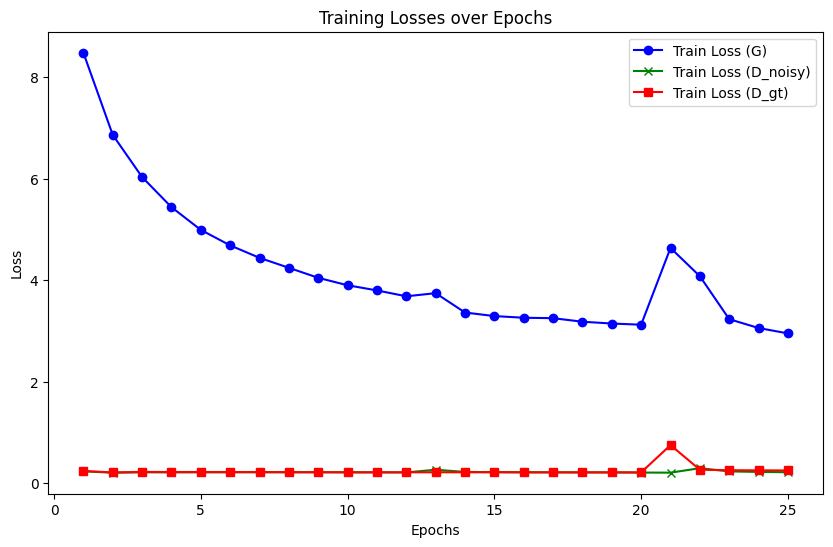

In [37]:
import matplotlib.pyplot as plt

# Assuming you have the following lists for epoch and loss values
epochs = [i for i in range(1, 26)]  # Correct number of epochs (1 to 26)
train_loss_G = [8.4837, 6.8652, 6.0341, 5.4412, 4.9934, 4.6880, 4.4429, 4.2462, 4.0492, 3.9025, 3.8008, 3.6850, 3.7468, 3.3653, 3.2954, 3.2624, 3.2539, 3.1839, 3.1486, 3.1252, 4.6378, 4.0808, 3.2343, 3.0599, 2.9544]  # 25 values (make sure this matches)
train_loss_D_noisy = [0.2376, 0.2092, 0.2175, 0.2158, 0.2169, 0.2171, 0.2184, 0.2168, 0.2186, 0.2188, 0.2164, 0.2148, 0.2680, 0.2247, 0.2203, 0.2193, 0.2172, 0.2165, 0.2155, 0.2125, 0.2103, 0.2984, 0.2351, 0.2254, 0.2188]  # 25 values
train_loss_D_gt = [0.2432, 0.2154, 0.2249, 0.2233, 0.2232, 0.2227, 0.2219, 0.2208, 0.2185, 0.2161, 0.2169, 0.2174, 0.2181, 0.2178, 0.2185, 0.2154, 0.2156, 0.2153, 0.2157, 0.2153, 0.7535, 0.2689, 0.2583, 0.2558, 0.2540]  # 25 values

# Make sure the lists are the same length
assert len(epochs) == len(train_loss_G) == len(train_loss_D_noisy) == len(train_loss_D_gt), "Epochs and loss lists must have the same length."

# Plotting
plt.figure(figsize=(10, 6))

# Plot training losses
plt.plot(epochs, train_loss_G, label="Train Loss (G)", color="blue", marker='o')
plt.plot(epochs, train_loss_D_noisy, label="Train Loss (D_noisy)", color="green", marker='x')
plt.plot(epochs, train_loss_D_gt, label="Train Loss (D_gt)", color="red", marker='s')

# Set plot labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses over Epochs')
plt.legend()

plt.show()


In [ ]:


# plt.figure(figsize=(10, 6))

# # Plot Training Loss
# plt.subplot(2, 1, 1)
# plt.plot(epochs, training_losses, label="Training Loss", color="blue")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.title("Training Loss Over Epochs")
# plt.legend()

# # Plot Evaluation Metrics
# plt.subplot(2, 1, 2)
# plt.plot(epochs, [avg_psnr] * len(epochs), label="PSNR (Test)", color="green")
# plt.plot(epochs, [avg_ssim] * len(epochs), label="SSIM (Test)", color="orange")
# plt.xlabel("Epochs")
# plt.ylabel("Metrics")
# plt.title("Evaluation Metrics")
# plt.legend()

# plt.tight_layout()
# plt.show()


In [41]:
# num_epochs = 50

# device = "cpu"

# # Move models to device
# for epoch in range(num_epochs):
#     G_noisy_to_gt.train()
#     G_gt_to_noisy.train()
    
#     for i, data in enumerate(train_loader):
#         real_noisy = data['noisy'].to(device)
#         real_gt = data['gt'].to(device)

#         # Train Generators
#         optimizer_G.zero_grad()

#         # Identity loss
#         same_gt = G_noisy_to_gt(real_gt)
#         loss_identity_gt = criterion_cycle(same_gt, real_gt) * lambda_cycle * 0.5

#         same_noisy = G_gt_to_noisy(real_noisy)
#         loss_identity_noisy = criterion_cycle(same_noisy, real_noisy) * lambda_cycle * 0.5

#         # GAN loss
#         fake_gt = G_noisy_to_gt(real_noisy)
#         pred_fake = D_gt(fake_gt)
#         loss_GAN_noisy_to_gt = criterion_GAN(pred_fake, torch.ones_like(pred_fake))

#         fake_noisy = G_gt_to_noisy(real_gt)
#         pred_fake_noisy = D_noisy(fake_noisy)
#         loss_GAN_gt_to_noisy = criterion_GAN(pred_fake_noisy, torch.ones_like(pred_fake_noisy))

#         # Cycle consistency loss
#         recovered_noisy = G_gt_to_noisy(fake_gt)
#         loss_cycle_noisy = criterion_cycle(recovered_noisy, real_noisy) * lambda_cycle

#         recovered_gt = G_noisy_to_gt(fake_noisy)
#         loss_cycle_gt = criterion_cycle(recovered_gt, real_gt) * lambda_cycle

#         loss_G = (
#             loss_identity_gt
#             + loss_identity_noisy
#             + loss_GAN_noisy_to_gt
#             + loss_GAN_gt_to_noisy
#             + loss_cycle_noisy
#             + loss_cycle_gt
#         )
#         loss_G.backward()
#         optimizer_G.step()

#         # Train Discriminators
#         optimizer_D_noisy.zero_grad()
#         optimizer_D_gt.zero_grad()

#         # D_noisy
#         pred_real_noisy = D_noisy(real_noisy)
#         loss_D_real_noisy = criterion_GAN(pred_real_noisy, torch.ones_like(pred_real_noisy))

#         pred_fake_noisy = D_noisy(fake_noisy.detach())
#         loss_D_fake_noisy = criterion_GAN(pred_fake_noisy, torch.zeros_like(pred_fake_noisy))

#         loss_D_noisy = (loss_D_real_noisy + loss_D_fake_noisy) * 0.5
#         loss_D_noisy.backward()
#         optimizer_D_noisy.step()

#         # D_gt
#         pred_real_gt = D_gt(real_gt)
#         loss_D_real_gt = criterion_GAN(pred_real_gt, torch.ones_like(pred_real_gt))

#         pred_fake_gt = D_gt(fake_gt.detach())
#         loss_D_fake_gt = criterion_GAN(pred_fake_gt, torch.zeros_like(pred_fake_gt))

#         loss_D_gt = (loss_D_real_gt + loss_D_fake_gt) * 0.5
#         loss_D_gt.backward()
#         optimizer_D_gt.step()

#     print(f"Epoch {epoch}/{num_epochs}, Loss_G: {loss_G.item()}, Loss_D_noisy: {loss_D_noisy.item()}, Loss_D_gt: {loss_D_gt.item()}")


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
G_noisy_to_gt.eval()
G_gt_to_noisy.eval()

for i, data in enumerate(test_loader):
    real_noisy = data['noisy'].to(device)
    real_gt = data['gt'].to(device)

    with torch.no_grad():
        restored_images = G_noisy_to_gt(real_noisy)

    # Save or display results for visualization
    save_image(real_noisy, f"test_results/noisy_{i}.png", normalize=True)
    save_image(restored_images, f"test_results/restored_{i}.png", normalize=True)
    save_image(real_gt, f"test_results/ground_truth_{i}.png", normalize=True)
